# LDA Parameter tuning 

Topic modeling is tricky, it is quite easy for a model to returns redundant topics, or topics with little to no meaning. We already know that it is important to feed the algorithm relevant data. But we haven't yet considered the importance of hyper-parameters (`alpha`, `eta`, `num_topics`, etc). These hyper-parameters greatly affect the outcome of the LDA algorithm. 

Our objective here is to generate the best possible general topic model on the elzée dataset. General topic model meaning covering all aspects of the dataset. For this model we have two possible candidates:
 1. Model $X$: model where we consider each document as a tweet and all 900 000 tweets are entered into the Document-Term matrix.
 2. Model $Y$: model for the last level of the community tree at the last timestamp.
 
To find which model is best, we want to find out which model returns the highest coherence score. The coherence score is a number between 0 and 1. Basically, the closer it is to 1, the better the model.

We want to find the optimal hyper-parameters for each model in order to obtain their highest possible coherence scores. 

In order to optimize these hyper-parameters, we devise a set of tests (performed on both possible models):

1. The first round of tests concerns `iterations` and `passes`. gensim suggests the follwing to choose: "First, enable logging, and set `eval_every = 1` in `LdaMulticore()`. When training the model look for a line in the log that looks something like this: 

    `2016-06-21 15:40:06,753 - gensim.models.ldamodel - DEBUG - 68/1566 documents converged within 400 iterations`

    If you set passes to 20 you will see this line 20 times. Make sure that by the final passes, most of the documents have converged. So you want to choose both passes and iterations to be high enough for this to happen."

    In our case, `passes=10` and `iterations=250` did the job for both models. As this involves looking at the log, there is no detailed code for this test.
    
    
2. The second round of tests concerns `num_topics`, `alpha` and `eta`. See <b>elyzeeTopicModeling.ipynb</b> for more details on these hyper-parameters. We devise a set of possible values for each hyper-parameter. We generate a model for each case and then calculate the coherence score. This of course is done for both possible models $X$ and $Y$. Let's dive into the code to explain further.


***

  ## <b>1.</b> <a href="#1">Model $X$</a>
 
 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>1.1.</b>  <a href="#1-1">Run tests function for model $X$</a>
 
 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>1.2.</b> <a href="#1-2">Run tests for model $X$</a>
 
 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>1.3.</b> <a href="#1-3">Plot model $X$ tests results</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>1.4.</b> <a href="#1-4">Help deciding what values of `alpha` and `eta` to use
</a>

## <b>2.</b> <a href="#2">Model $Y$</a>
 
 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.1.</b>  <a href="#2-1">Run tests function for model $Y$</a>
 
 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.2.</b> <a href="#1-2">Run tests for model $Y$</a>
 
 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.3.</b> <a href="#2-3">Plot model $Y$ tests results</a>

 ### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>2.4.</b> <a href="#2-4">Help deciding what values of `alpha` and `eta` to use
</a>

## <b>3.</b> <a href="#3">Final comparisons and conclusion</a>


# Necessary libraries

In [1]:
import json
import pickle
import re

# removing stopwords from tweets
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS
from stop_words import get_stop_words

# for comparing dates
from datetime import datetime

# gensim
from gensim import corpora, models, similarities
from gensim import models
import pyLDAvis
import pyLDAvis.gensim
from gensim.summarization import keywords

# parameter tuning
from gensim.models import CoherenceModel
from collections import defaultdict 
import numpy as np
import matplotlib.pyplot as plt

# word clouds
from wordcloud import WordCloud

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import main notebook


In [3]:
from ipynb.fs.full.elyzeeTopicModeling import *

# Compute coherence score function

In [4]:
def computeCoherenceScore(model,ppDocs,dictionary):
    """
    
    model (gensim.models.ldamulticore.LdaMulticore): model for which we want the cs
    ppComsDict (dict): preprocessed communities
    dictionary (gensim.corpora.dictionary.Dictionary): model dictionary
    
    returns coherence score for model
    """
    if type(ppDocs) == dict:
        ppDocs = [[item for sublist in tweets for item in sublist] for tweets in list(ppDocs.values())]
    
    coherenceModel = CoherenceModel(model=model, texts=ppDocs, dictionary=dictionary, coherence='c_v')
    coherenceScore = coherenceModel.get_coherence()
    
    return coherenceScore

# 1. Model $X$
<div id="1"></div>

## 1.1. Run tests function for model $X$
<div id="1-1"></div>

In [6]:
# Utiliy function to create multi-dimensional dictionary 
def multi_dict(K, type): 
    if K == 1: 
        return defaultdict(type) 
    else: 
        return defaultdict(lambda: multi_dict(K-1, type)) 

In [7]:
def runTestsModel1(topicsRange,alphaTests,etaTests):

    """
    run tests on model 1 for alpha, eta and num_topics parameters
    (calculate coherence score for all (nbAlphas * nbEtas * nbNumTopics) cases)
    
    returns 3D dictionary. ex tests[10][0.01][0.61] = 0.36
                                    t     a    e           t (topic), a (alpha), e (eta)
    """
    
    tests = {}
    tests = multi_dict(3, int) 

    for nbTopics in topicsRange:
        for alpha in alphaTests:
            for eta in etaTests:
                
                print(nbTopics,alpha,eta)
                
                # calculate model
                model, dictionary, corpus, ppTweets = LDAModelForAllTweets(
                              numTopics=nbTopics,
                              passes=10,
                              alpha=alpha,
                              eta=eta,
                              iterations=200,
                              eval_every=10)
                
                # calculaute coherence score
                cs = computeCoherenceScore(model,ppTweets,dictionary)
                
                if eta == 'symmetric' and alpha == 'symmetric':
                    tests[nbTopics][-1][-1] = cs
                elif eta == 'symmetric' and alpha == 'asymmetric':
                    tests[nbTopics][-2][-1] = cs
                elif eta == 'symmetric' and alpha not in ['symmetric','asymmetric']:
                    tests[nbTopics][alpha][-1] = cs
                elif alpha == 'symmetric' and eta != 'symmetric':
                    tests[nbTopics][-1][eta] = cs
                elif alpha == 'asymmetric' and eta != 'symmetric':
                    tests[nbTopics][-2][eta] = cs
                else:
                    tests[nbTopics][alpha][eta] = cs
    return tests

## 1.2. Run tests for model $X$
<div id="1-2"></div>

For model $X$ let:

 - `num_topics in [50,100,150]`
 
 - `alpha in [0.000001,0.001,0.1,0.3,0.6,'symmetric']`
 
 - `eta in [0.3,0.6,0.9,None]`
 
We wan't a lot of topics to represent the dataset so at least fifty. We couldn't add more possible values for `num_topics` because it just takes too long to run (20 minutes per test), we don't have time. These values will have to do for now. Instead of performing a triple `for loop`, we decided to cut these tests up into smaller chunks. Each round of tests is dependant on the previous one. For example if in this first round we find that `alpha=0.6` doesn't produce good coherence scores, then we'll try other values on next tests or only try `alpha=0.6` once or twice more.

### Round 1

In [8]:

# Alpha parameter
alphaTests = [0.01,0.3,0.6] # (0.01, 1, 0.3)

# Eta parameter
etaTests = [0.3,0.6]

# num_topics parameter
topicsRange = [50]

tests1Model1 = runTestsModel1([50],alphaTests,etaTests)

50 0.01 0.3
50 0.01 0.6
50 0.3 0.3
50 0.3 0.6
50 0.6 0.3
50 0.6 0.6


### Round 2

In [13]:
# Alpha parameter
alphaTests = [0.001,"symmetric"] # (0.01, 1, 0.3)

# Eta parameter
etaTests = [0.3,0.6,None]

# num_topics parameter
topicsRange = [50]

tests2Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

50 0.001 0.3
50 0.001 0.6
50 0.001 None
50 symmetric 0.3
50 symmetric 0.6
50 symmetric None


### Round 3

In [26]:
# Alpha parameter
alphaTests = [0.000001] # (0.01, 1, 0.3)

# Eta parameter
etaTests = [0.3,0.6]

# num_topics parameter
topicsRange = [50]

tests3Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

50 1e-06 0.3
50 1e-06 0.6


### Round 4

In [29]:
# Alpha parameter
alphaTests = [0.000001] # (0.01, 1, 0.3)

# Eta parameter
etaTests = [None]

# num_topics parameter
topicsRange = [50]

tests4Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

50 1e-06 None


### Round 5

In [41]:

# Alpha parameter
alphaTests = [0.000001,0.01] # (0.01, 1, 0.3)

# Eta parameter
etaTests = [0.9]

# num_topics parameter
topicsRange = [50]

tests5Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

50 1e-06 0.9
50 0.01 0.9


### Round 6

In [43]:
# Alpha parameter
alphaTests = [0.000001] # (0.01, 1, 0.3)

# Eta parameter
etaTests = [0.9]

# num_topics parameter
topicsRange = [100]

tests6Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

100 1e-06 0.9


### Round 7

In [45]:
# Alpha parameter
alphaTests = [0.01,0.3] # (0.01, 1, 0.3)

# Eta parameter
etaTests = [0.6,0.9]

# num_topics parameter
topicsRange = [100]

tests7Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

100 0.01 0.6
100 0.01 0.9
100 0.3 0.6
100 0.3 0.9


### Round 8

In [49]:
# Alpha parameter
alphaTests = [0.000001]

# Eta parameter
etaTests = [0.9]

# num_topics parameter
topicsRange = [150]

tests8Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

150 1e-06 0.9


### Round 9

In [53]:
# Alpha parameter
alphaTests = [0.000001]

# Eta parameter
etaTests = [0.9]

# num_topics parameter
topicsRange = [145]

tests9Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

145 1e-06 0.9


### Round 10

In [371]:
# Alpha parameter
alphaTests = [0.000001]

# Eta parameter
etaTests = [0.9]

# num_topics parameter
topicsRange = [90,110]

tests10Model1 = runTestsModel1(topicsRange,alphaTests,etaTests)

90 1e-06 0.9
110 1e-06 0.9


### Raw results

In [88]:
tests1Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {50: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {0.01: defaultdict(int,
                                      {0.3: 0.31937597471093226,
                                       0.6: 0.36183911574782834}),
                          0.3: defaultdict(int,
                                      {0.3: 0.3313338198283578,
                                       0.6: 0.3465848367914958}),
                          0.6: defaultdict(int,
                                      {0.3: 0.1697220355466482,
                                       0.6: 0.15134074431689684})})})

In [94]:
tests2Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {50: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {0.001: defaultdict(int,
                                      {0.3: 0.32190602970261084,
                                       0.6: 0.35736087244370096,
                                       None: 0.32330096976538014}),
                          -1: defaultdict(int,
                                      {0.3: 0.32665031378269727,
                                       0.6: 0.3521716239134403,
                                       None: 0.2995446374546204})})})

In [95]:
tests3Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {50: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {1e-06: defaultdict(int,
                                      {0.3: 0.33524907901973255,
                                       0.6: 0.3584871189210637})})})

In [96]:
tests4Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {50: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {1e-06: defaultdict(int,
                                      {None: 0.3094976376301435})})})

In [97]:
tests5Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {50: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {1e-06: defaultdict(int, {0.9: 0.4145539268460638}),
                          0.01: defaultdict(int,
                                      {0.9: 0.40547977424181675})})})

In [98]:
tests6Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {100: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {1e-06: defaultdict(int,
                                      {0.9: 0.4512357082400142})})})

In [476]:
tests7Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {100: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {0.01: defaultdict(int,
                                      {0.6: 0.405396127216225,
                                       0.9: 0.43947014668578305,
                                       0.3: 0,
                                       None: 0}),
                          0.3: defaultdict(int,
                                      {0.6: 0.35732285584542156,
                                       0.9: 0.35760843576235224,
                                       0.3: 0,
                                       None: 0})})})

In [475]:
tests8Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {150: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {1e-06: defaultdict(int,
                                      {0.9: 0.119022069680323,
                                       0.3: 0,
                                       0.6: 0,
                                       None: 0})})})

In [474]:
tests9Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {145: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {1e-06: defaultdict(int,
                                      {0.9: 0.12417560069572438,
                                       0.3: 0,
                                       0.6: 0,
                                       None: 0})})})

In [473]:
tests10Model1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {90: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {1e-06: defaultdict(int,
                                      {0.9: 0.5089198742920636,
                                       0.3: 0,
                                       0.6: 0,
                                       None: 0})}),
             110: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {1e-06: defaultdict(int,
                                      {0.9: 0.38947412700678596,
                                       0.3: 0,
                                       0.6: 0,
                                       None: 0})})})

### Merge results
Here we are merging all tests into one dictionary for easier use

In [477]:
import copy
testsModel1 = copy.deepcopy(tests1Model1)
testsModel1[50][0.001] = copy.deepcopy(tests2Model1[50][0.001])
testsModel1[50][-1] = copy.deepcopy(tests2Model1[50][-1])
testsModel1[50][0.000001] = copy.deepcopy(tests3Model1[50][0.000001])
testsModel1[50][0.000001][None] = copy.deepcopy(tests4Model1[50][0.000001][None])
testsModel1[50][0.000001][0.9] = copy.deepcopy(tests5Model1[50][0.000001][0.9])
testsModel1[50][0.01][0.9] = copy.deepcopy(tests5Model1[50][0.01][0.9])
testsModel1[100][0.000001][0.9] = copy.deepcopy(tests6Model1[100][0.000001][0.9])
testsModel1[100][0.01] = copy.deepcopy(tests7Model1[100][0.01])
testsModel1[100][0.3] = copy.deepcopy(tests7Model1[100][0.3])
testsModel1[150][0.000001] = copy.deepcopy(tests8Model1[150][0.000001])
testsModel1[145][0.000001] = copy.deepcopy(tests9Model1[145][0.000001])
testsModel1[90][0.000001] = copy.deepcopy(tests10Model1[90][0.000001])
testsModel1[110][0.000001] = copy.deepcopy(tests10Model1[110][0.000001])

In [478]:
testsModel1

defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
            {50: defaultdict(<function __main__.multi_dict.<locals>.<lambda>()>,
                         {0.01: defaultdict(int,
                                      {0.3: 0.31937597471093226,
                                       0.6: 0.36183911574782834,
                                       0.9: 0.40547977424181675}),
                          0.3: defaultdict(int,
                                      {0.3: 0.3313338198283578,
                                       0.6: 0.3465848367914958}),
                          0.6: defaultdict(int,
                                      {0.3: 0.1697220355466482,
                                       0.6: 0.15134074431689684}),
                          0.001: defaultdict(int,
                                      {0.3: 0.32190602970261084,
                                       0.6: 0.35736087244370096,
                                       None: 0.32330096976538014,
      

We can already see that `num_topics=90`, `alpha=1e-06` and `eta=0.9` produces the best coherence score. For `alpha` this makes sense as each document is a tweet. We can assume that each tweet talks about one topic. There are 900 000 tweets so logically alpha=$\frac{1}{1 000 000}$ But let's do some futher analysisto find out more:

## 1.3. Plot model $X$ tests results
<div id="1-3"></div>
Let's draw a scatter plot. The x axis represents `num_topics` and the y axis represents the coherence score. For each possible number of topics, we plot all the calculated coherence values onto $d:x=\text{num_topics}$. The orange dots are the average coherence scores for the given number of topics. We also plot a line passing through all orange dots to visualise better the evolution of the coherence score depending on the number of topics.

In [491]:
def scatterCoherenceScores(tests):

    coherenceScoresForEachNumTopics = {}
    for t in tests.keys():
        cScores = []
        for a in tests[t]:
            for e in tests[t][a]:
                cScores.append((tests[t][a][e],t))
        coherenceScoresForEachNumTopics[t] = list(filter(lambda x:x[0] != 0.0,cScores))
        
    avgCSForEachNbTopics = {}
    for t in sorted(tests):
        tmp = [couple[0] for couple in coherenceScoresForEachNumTopics[t]]
        if tmp != []:
            avgCSForEachNbTopics[t] = sum(tmp)/len(tmp)

    x = [couple[1] for couple in [item for sublist in list(coherenceScoresForEachNumTopics.values()) for item in sublist]]
    y = [couple[0] for couple in [item for sublist in list(coherenceScoresForEachNumTopics.values()) for item in sublist]] 
    
    plt.figure(figsize=(7,7))
    plt.xlabel('number of topics')
    plt.ylabel('coherence score')
    plt.scatter(x,y)
    plt.scatter(sorted([t for t in tests]),list(avgCSForEachNbTopics.values()))
    plt.plot(sorted([t for t in tests]),list(avgCSForEachNbTopics.values()))
    plt.show()

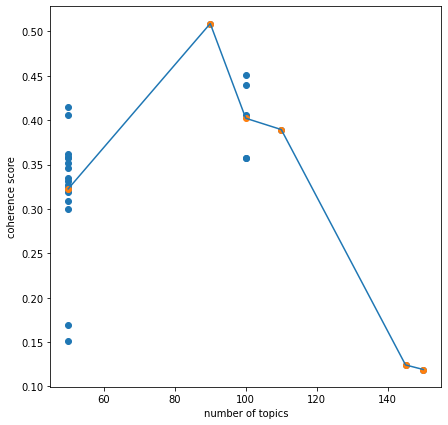

In [492]:
scatterCoherenceScores(testsModel1)

As we can see, as we approach 100 topics, the coherence score increases. As we add more topics past 100, the coherence score declines.

## 1.4. Help deciding what values of `alpha` and `eta` to use
<div id="1-4"></div>

We have seen that `alpha=1e-06` and `eta=0.9` gave good results. Let's dig a little deeper. First of all, for each set of tests where alpha and eta are constant (nbTopics is not), we calculate the average coherence score. For this we use the `getAverageCoherenceScores()` function:

In [324]:
def getAverageCoherenceScores(tests,topicsRange,alphaTests,etaTests):
    """
    returns list of length len(topicsRange) where each element is (avg, (alpha, eta))
    avg is the average coherence score over range(number of topics) on a set of tests (30 tests, 30 = 6 alphas x 5 etas) where alpha and eta fixed.
    """
    
    averages = []
    for alpha in alphaTests:
        for eta in etaTests:
            tmp = [tests[num][alpha][eta] for num in topicsRange]
            average = (sum(tmp)/len(tmp),(alpha,eta))
            averages.append(average)
    return averages

Next, let's take alpha = 0.3 for example. We extract the average coherence scores from the previous function for which alpha is equal to 0.3, and then calculate the average score from the new set of scores. We do this for all possible values of alpha. The highest value we get is the best possible value for alpha. We use `evaluateAlpha()` for this:   

In [325]:
def evaluateAlpha(tests,topicsRange,alphaTests,etaTests):
    """
    returns sorted list where each element is (avg, alpha)
    avg is the average coherence score where alpha=alpha
    """
    
    avgSorted = sorted(getAverageCoherenceScores(tests,topicsRange,alphaTests,etaTests), key=lambda x:x[0],reverse=True)
    # list(filter(lambda x:x[0] != -1,avgSorted))
    
    myList = []
    for a in alphaTests:
        tmp = [elt[0] for elt in avgSorted if elt[1][0] == a]
        myList.append((sum(tmp)/len(tmp),a))
    return sorted(myList,key=lambda x:x[0],reverse=True)

In [326]:
def evaluateEta(tests,topicsRange,alphaTests,etaTests):
    """
    returns sorted list where each element is (avg, eta)
    avg is the average coherence score where eta=eta
    """
    
    avgSorted = sorted(getAverageCoherenceScores(tests,topicsRange,alphaTests,etaTests), key=lambda x:x[0],reverse=True)
    
    myList = []
    for e in etaTests:
        tmp = [elt[0] for elt in avgSorted if elt[1][1] == e]
        myList.append((sum(tmp)/len(tmp),e))
    return sorted(myList,key=lambda x:x[0],reverse=True)

In [376]:
topicsRangeX = [50,90,100,110,145,150]
alphaTestsX = [0.000001,0.001,0.01,0.3,0.6,-1]
etaTestsX = [0.3,0.6,0.9,None]

In [378]:
evaluateAlpha(testsModel1,topicsRangeX,alphaTestsX,etaTestsX)

[(0.12544229759716313, 1e-06),
 (0.08048171410844106, 0.01),
 (0.05803541450948448, 0.3),
 (0.041773661329653836, 0.001),
 (0.04076527396461492, -1),
 (0.01337761582764771, 0.6)]

In [379]:
evaluateEta(testsModel1,topicsRangeX,alphaTestsX,etaTestsX)

[(0.08916499065141463, 0.9),
 (0.07473620264433535, 0.6),
 (0.05011770146086053, 0.3),
 (0.025898423468059557, None)]

In [380]:
sorted(getAverageCoherenceScores(testsModel1,topicsRangeX,alphaTestsX,etaTestsX), key=lambda x:x[0],reverse=True)[:5]

[(0.3345635511268292, (1e-06, 0.9)),
 (0.14082498682126662, (0.01, 0.9)),
 (0.1278725404940089, (0.01, 0.6)),
 (0.11731794877281958, (0.3, 0.6)),
 (0.05974785315351062, (1e-06, 0.6))]

<b>IMPORTANT</b>: here the average coherence scores are very low, this is because we calculated the averages for all possible values but we didn't conduct tests for all possible values. As said before the "missing gaps" are replaced with 0. All the zeros bring down the averages. But this doesn't affet the overall interpretation of the averages. 

We can see that the average coherence score is highest for `alpha = 1e-06` and `eta = 0.9` (first two outputs). We can also see that overall, the highest average coherence score is for `alpha = 1e-06` and `eta = 0.9`. These values seem pertinent.

# 2. Model $Y$
<div id="2"></div>

## 2.1. Run tests function for model $Y$
<div id="2-1"></div>

### Retieve tweet data for model $Y$
Note that for this model we ran two sets of tests. The first set was for data not including users connections. The second with users connections. The following cell retrieves tweets from users and users connections. This cell was altered for the other set of tests.

In [135]:
comsModel2 = getTweetsFromAllUsersAndUsersConnectionsFromAllCommunitiesFromLevel(len(jtweets),
                                                                list(data['communities'].keys())[-1],
                                                                list(getLevelsFromTimeStamp(list(data['communities'].keys())[-1]))[-1],
                                                                500)

# separate the raw tweets from the pre processed ones
rawComsDictModel2 = {k:v[1] for (k,v) in comsModel2.items()}
ppComsDictModel2 = {k:v[0] for (k,v) in comsModel2.items()}

### The function

In [83]:
def runTestsModel2(topicsRange,alphaTests,etaTests):

    """
    run tests on model 1 for alpha, eta and num_topics parameters
    (calculate coherence score for all (nbAlphas * nbEtas * nbNumTopics) cases)
    
    returns 3D dictionary. ex tests[10][0.01][0.61] = 0.36
                                    t     a    e           t (topic), a (alpha), e (eta)
    """
    
    tests = {}
    tests = multi_dict(3, int) 

    for nbTopics in topicsRange:
        for alpha in alphaTests:
            for eta in etaTests:
                
                print(nbTopics,alpha,eta)
                
                # calculate model
                model, dictionary, corpusComs, docTopicDistSorted, ppComsDict, rawComsDict = BuildModelForLevel(
                       nbTweets=len(jtweets)-1, 
                       timeStamp=list(data['communities'].keys())[-1], 
                       level=list(getLevelsFromTimeStamp(list(data['communities'].keys())[-1]))[-1], 
                       dateMargin=500, 
                       modelType=0, 
                       connectionsToo=False, 
                       numTopics=nbTopics, 
                       passes=10, 
                       ppComsDict=ppComsDictModel2,
                       rawComsDict=rawComsDictModel2,
                       alpha=alpha,
                       eta=eta,
                       eval_every=10,
                       iterations=200)
                
                # calculaute coherence score
                cs = computeCoherenceScore(model,ppComsDict,dictionary)
                
                if eta == 'symmetric' and alpha == 'symmetric':
                    tests[nbTopics][-1][-1] = cs
                elif eta == 'symmetric' and alpha == 'asymmetric':
                    tests[nbTopics][-2][-1] = cs
                elif eta == 'symmetric' and alpha not in ['symmetric','asymmetric']:
                    tests[nbTopics][alpha][-1] = cs
                elif alpha == 'symmetric' and eta != 'symmetric':
                    tests[nbTopics][-1][eta] = cs
                elif alpha == 'asymmetric' and eta != 'symmetric':
                    tests[nbTopics][-2][eta] = cs
                else:
                    tests[nbTopics][alpha][eta] = cs
    return tests

## 2.2. Run tests for model $Y$
<div id="2-2"></div>

For model $Y$ let:

 - `num_topics in [50,75,100,125,150]`
 
 - `alpha in [0.000001,0.01,0.3]`
 
 - `eta in [0.6,0.9,None]`
 
Just like for model $X$, we want a lot of topics to represent the dataset so at least fifty. We added more possible number of topics here as there is less data to process. As seen previously, the coherence scores for model $X$ were quite good for `alpha` closer to 0 and `eta` closer to 1. So their possible values here are inspired by our previous results. We perform a triple `for loop` over the three hyper-parameters and calculate the coherence scores for each model produced. So in this case, 5x3x3 = 45 coherence scores calculated.
    
This process is done for both `userConnections=True` and `userConnections=False` cases

### Case `userConnections=False`

In [79]:
# Alpha parameter
alphaTests = [0.000001,0.01,0.3]

# Eta parameter
etaTests = [0.6,0.9,None]

# num_topics parameter
topicsRange = [50,75,100,125,150]

tests1Model2 = runTestsModel2(topicsRange,alphaTests,etaTests) # not connections

50 1e-06 0.6
50 1e-06 0.9
50 1e-06 None
50 0.01 0.6
50 0.01 0.9
50 0.01 None
50 0.3 0.6
50 0.3 0.9
50 0.3 None
75 1e-06 0.6
75 1e-06 0.9
75 1e-06 None
75 0.01 0.6


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/jupyter/anaconda3/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/jupyter/anaconda3/lib/python3.6/multiprocessing/pool.py", line 615, in _terminate_pool
    p.terminate()
  File "/home/jupyter/anaconda3/lib/python3.6/multiprocessing/process.py", line 116, in terminate
    self._popen.terminate()
AttributeError: 'NoneType' object has no attribute 'terminate'


75 0.01 0.9
75 0.01 None
75 0.3 0.6
75 0.3 0.9
75 0.3 None
100 1e-06 0.6
100 1e-06 0.9
100 1e-06 None
100 0.01 0.6
100 0.01 0.9
100 0.01 None
100 0.3 0.6
100 0.3 0.9
100 0.3 None
125 1e-06 0.6
125 1e-06 0.9
125 1e-06 None
125 0.01 0.6
125 0.01 0.9
125 0.01 None
125 0.3 0.6
125 0.3 0.9
125 0.3 None
150 1e-06 0.6
150 1e-06 0.9
150 1e-06 None
150 0.01 0.6
150 0.01 0.9
150 0.01 None
150 0.3 0.6
150 0.3 0.9
150 0.3 None


### Case `userConnections=True`

In [84]:
# Alpha parameter
alphaTests = [0.000001,0.01,0.3]

# Eta parameter
etaTests = [0.6,0.9,None]

# num_topics parameter
topicsRange = [50,75,100,125,150]

tests2Model2 = runTestsModel2(topicsRange,alphaTests,etaTests) # with connections

50 1e-06 0.6
50 1e-06 0.9
50 1e-06 None
50 0.01 0.6
50 0.01 0.9
50 0.01 None
50 0.3 0.6
50 0.3 0.9
50 0.3 None
75 1e-06 0.6
75 1e-06 0.9
75 1e-06 None
75 0.01 0.6
75 0.01 0.9
75 0.01 None
75 0.3 0.6
75 0.3 0.9
75 0.3 None
100 1e-06 0.6
100 1e-06 0.9
100 1e-06 None
100 0.01 0.6
100 0.01 0.9
100 0.01 None
100 0.3 0.6
100 0.3 0.9
100 0.3 None
125 1e-06 0.6
125 1e-06 0.9
125 1e-06 None
125 0.01 0.6
125 0.01 0.9
125 0.01 None
125 0.3 0.6
125 0.3 0.9
125 0.3 None
150 1e-06 0.6
150 1e-06 0.9
150 1e-06 None
150 0.01 0.6
150 0.01 0.9
150 0.01 None
150 0.3 0.6
150 0.3 0.9
150 0.3 None


## 2.3. Plot model $Y$ tests results
<div id="2-3"></div>
The first and most obvious way to study the results from our tests is to plot some graphs. For each graph, the x axis is the number of topics, the y axis is the coherence scores and alpha and eta are fixed. `plotAllCoherenceValuesGraphs()` allows us to plot all the graphs as subplots.

In [216]:
def plotAllCoherenceValuesGraphs(tests,topicsRange,alphaTests,etaTests):
    """
    plot every possible coherence values graph
    (for all values of alpha and eta)
    """
    plt.figure(figsize=(10,10))
    couples = []
    for topic in topicsRange:
        for alpha in alphaTests:
            for eta in etaTests:
                if testsModel1[topic][alpha][eta] != 0:
                    plt.plot(topicsRange, [tests[num][alpha][eta] for num in topicsRange])
                    couples.append((str(alpha),str(eta)))
                #plotCoherenceValues(tests,topicsRange,alpha,eta)
                #if eta == 'symmetric' and alpha == 'symmetric':
                #    plotCoherenceValues(tests,topicsRange,-1,-1)
                #elif eta == 'symmetric' and alpha == 'asymmetric':
                #    plotCoherenceValues(tests,topicsRange,-2,-1)
                #elif eta == 'symmetric' and alpha not in ['symmetric','asymmetric']:
                #    plotCoherenceValues(tests,topicsRange,alpha,-1)
                #elif alpha == 'symmetric' and eta != 'symmetric':
                #    plotCoherenceValues(tests,topicsRange,-1,eta)
                #elif alpha == 'asymmetric' and eta != 'symmetric':
                #    plotCoherenceValues(tests,topicsRange,-2,eta)
                #else:
                #    plotCoherenceValues(tests,topicsRange,alpha,eta)
       
    plt.xlabel("Number of topics")
    plt.ylabel("Coherence score")
    
    plt.legend(couples, loc='best')
    plt.show()

In [232]:
topicsRangeY = [50,75,100,125,150]
alphaTestsY = [0.000001,0.01,0.3]
etaTestsY = [0.6,0.9,None]

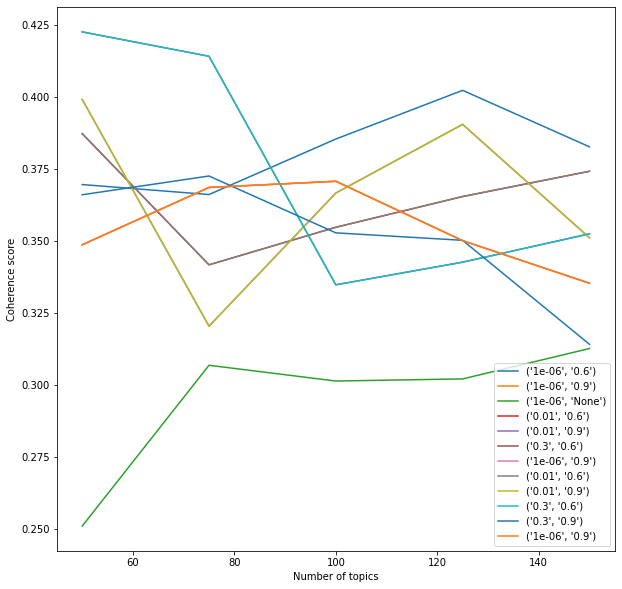

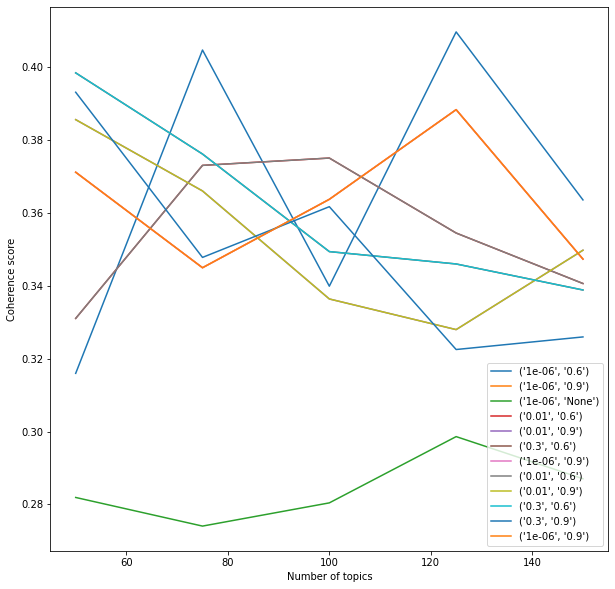

In [269]:
plotAllCoherenceValuesGraphs(tests1Model2,topicsRangeY,alphaTestsY,etaTestsY)
plotAllCoherenceValuesGraphs(tests2Model2,topicsRangeY,alphaTestsY,etaTestsY)

From these results, we can see that in increase in the number of topics doesn't correlate to a convergence of coherence scores, not very interesting...

## 2.4. Decide what values of `alpha` and `eta` to use
<div id="2-4"></div>

For this we can use the `getAverageCoherenceScores()`, `evaluateAlpha()` and `evaluateEta()` functions used previously for model $X$

### Model without users connections:

In [330]:
evaluateAlpha(tests1Model2,topicsRangeY,alphaTestsY,etaTestsY)

[(0.34363069032224924, 1e-06),
 (0.33979218435160075, 0.01),
 (0.3315397430988543, 0.3)]

In [331]:
evaluateEta(tests1Model2,topicsRangeY,alphaTestsY,etaTestsY)

[(0.3731464368881248, 0.6),
 (0.3572014479601073, 0.9),
 (0.2846147329244721, None)]

In [333]:
sorted(getAverageCoherenceScores(tests1Model2,topicsRangeY,alphaTestsY,etaTestsY), key=lambda x:x[0],reverse=True)[:5]

[(0.3812940717661849, (1e-06, 0.6)),
 (0.3733976450058507, (0.3, 0.6)),
 (0.36563178118798073, (0.01, 0.9)),
 (0.3647475938923389, (0.01, 0.6)),
 (0.35475212122612365, (1e-06, 0.9))]

From these results we can cleary see that the lower `alpha` is, the better. But for `eta` it seems as 0.6 is a good value.

### Model with users connections:

In [272]:
evaluateAlpha(tests2Model2,topicsRangeY,alphaTestsY,etaTestsY)

[(0.3380446875102829, 1e-06),
 (0.33004925968496257, 0.01),
 (0.32732027867048635, 0.3)]

In [273]:
evaluateEta(tests2Model2,topicsRangeY,alphaTestsY,etaTestsY)

[(0.36105663729401183, 0.6),
 (0.3554283649940209, 0.9),
 (0.2789292235776991, None)]

In [274]:
sorted(getAverageCoherenceScores(tests2Model2,topicsRangeY,alphaTestsY,etaTestsY), key=lambda x:x[0],reverse=True)[:5]

[(0.3666879672583233, (1e-06, 0.6)),
 (0.3630347136556321, (1e-06, 0.9)),
 (0.36169400136456925, (0.3, 0.6)),
 (0.35478794325914287, (0.01, 0.6)),
 (0.3530891306288345, (0.01, 0.9))]

From these results we can see that the values for `alpha` and `eta` don't make much of a difference. Although, `eta = None` does seem to not perform well.

# 3. Final comparisons and conclusion
<div id="3"></div>

### Overall average coherence scores:
First let's calculate the average overall coherence score for all three models we have studied:
 

In [468]:
def overallAverageCS(tests):
    """
    calulate overall average coherence score for a set of tests
    tests (defaultdict)
    """
    
    allVals = []
    for t in tests.:
        print(t)
        for a in tests[t]:
            for e in tests[t][a]:
                allVals.append(tests[t][a][e])
                
    flt = list(filter(lambda x:x != 0,allVals))
    
    return sum(flt)/len(flt)

### Model $X$

In [469]:
overallAverageCS(testsModel1)

50
100
150
145
90
110
0.01
0.3
0.6
0.001
-1
1e-06


0.33219320984954315

### Model $Y$ (without connections)

In [360]:
overallAverageCS(tests1Model2)

0.33832087259090143

### Model $Y$ (with connections)

In [361]:
overallAverageCS(tests2Model2)

0.33180474195524395

There is only a difference on the order of $10^{-2}$ which is pretty insignificant. So of the three models, there isn't much of a difference on average. But remember for model $X$, we perfomed less tests. 

### Highest coherence scores:
Now let's calculate the highest coherence score for all three models we have studied:


In [366]:
def maxCS(tests):
    """
    calulate overall average coherence score for a set of tests
    tests (defaultdict)
    """
    
    allVals = []
    for t in tests:
        for a in tests[t]:
            for e in tests[t][a]:
                allVals.append(tests[t][a][e])
                
    flt = list(filter(lambda x:x != 0,allVals))
    
    return max(flt)

### Model $X$

In [382]:
maxCS(testsModel1)

0.5089198742920636

### Model $Y$ (without connections)

In [368]:
maxCS(tests1Model2)

0.4226764586381621

### Model $Y$ (with connections)

In [369]:
maxCS(tests2Model2)

0.40956212493778565

It is clear that here, model $X$ gives the highest coherence score by a significant margin. But maybe if more tests were done for model $Y$, we might have gotten higher than 0.5. We'll never know... 

But we can be sure on one thing: for all models, it's good to have alpha close to 0 and eta close to 1 (`alpha`$\sim$ 0.000001 and `eta` $\sim$ 0.9).

As the averages are very similar, that model $X$ gives us the highest coherence score, that there is more data in model $X$, it is safe to conclude that model $X$ will be our general model with `alpha=0.000001` and `eta=0.9`.